## GBC Model Development

### Libraries

In [106]:
import polars as pl
import pandas as pd
import numpy as np
import os
import sys
import time
import random
import itertools
import json
import pickle
import joblib
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.colors import ListedColormap

# from sklearn import datasets, metrics, linear_model, svm
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    # RandomizedSearchCV,
    GridSearchCV,
    # KFold,
)
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
# from sklearn.datasets import (
#     make_moons,
#     make_circles,
#     make_classification,
#     make_blobs,
#     make_checkerboard,
# # )
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.cluster import KMeans
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    # RandomForestClassifier,
    # AdaBoostClassifier,
    # BaggingClassifier,
    # ExtraTreesClassifier as et,
    GradientBoostingClassifier
)
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    f1_score, matthews_corrcoef, brier_score_loss
)

import shap
# import xgboost as xgb
# import lightgbm
# from imblearn.over_sampling import SMOTE
# import miceforest as mf

# import pycaret
# from pycaret.classification import *

# import torch
# from torch.utils.data import Dataset, DataLoader
# import torch.nn as nn

# Torch CUDA availability flag
# if torch.cuda.is_available():
#     is_cuda = True
import warnings
%matplotlib inline

### Set Seeds

In [107]:
def set_seeds(seed: int = 42):
    """
    Set seeds for Python, NumPy, and environment-level hashing to ensure 
    reproducibility across data loading, CV splits, and model training.

    Parameters
    ----------
    seed : int
        Random seed to apply globally.
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seeds(42)

### Data Prep

#### Choosing ABP or PPG

In [108]:
# Pick Feature Set to use
FeatureChoice = "ABP" # Either "ABP" or "PPG" or "ABP_PPG"
# FeatureChoice = "PPG"
FeatureChoice = "ABP_PPG"

if FeatureChoice == "ABP":
    featuresFile = 'ABP_FEATURE_LIBRARY_MLORD_DATASET.csv'
    outcomesFile = 'Feature_ABP_Outcomes.csv'
    param_grid = {
        "loss": ["log_loss"],
        "learning_rate": [0.01, 0.03, 0.1],
        "max_depth": [2, 3],            # shallower
        "min_samples_split": [4, 8, 12], 
        "min_samples_leaf": [2, 4],     # prevent tiny leaves
        "n_estimators": [50, 100, 150], # fewer trees needed
        "max_features": ["sqrt", None], 
        "subsample": [0.7, 0.85, 1.0],
    }
elif FeatureChoice == 'PPG':
    featuresFile = 'PPG_FEATURE_LIBRARY_MLORD_DATASET.csv'
    outcomesFile = 'Feature_PPG_Outcomes.csv'
    param_grid = {
        "loss": ["log_loss"],
        "learning_rate": [0.03, 0.1],
        "max_depth": [2, 3],          # deeper allowed if go to 4
        "min_samples_split": [4, 8],
        "min_samples_leaf": [2, 4],
        "n_estimators": [100, 200], # more trees for larger dataset
        "max_features": ["sqrt", None],
        "subsample": [0.7, 0.85],
    }
elif FeatureChoice == 'ABP_PPG':
    PPG_featuresFile = 'PPG_FEATURE_LIBRARY_MLORD_DATASET.csv'
    PPG_outcomesFile = 'Feature_PPG_Outcomes.csv'
    ABP_featuresFile = 'ABP_FEATURE_LIBRARY_MLORD_DATASET.csv'
    ABP_outcomesFile = 'Feature_ABP_Outcomes.csv'
    param_grid = {
        "loss": ["log_loss"],
        "learning_rate": [0.01, 0.03, 0.1],
        "max_depth": [2, 3],            # shallower
        "min_samples_split": [4, 8, 12], 
        "min_samples_leaf": [2, 4],     # prevent tiny leaves
        "n_estimators": [50, 100, 150], # fewer trees needed
        "max_features": ["sqrt", None], 
        "subsample": [0.7, 0.85, 1.0],
    }
else:
    raise SystemExit("Choose either ABP or PPG")

### Start timing

In [109]:
timefilelog = f"outputs/{FeatureChoice}_timing.txt"
def log_time(event_name, event_time):
    with open(timefilelog, "a") as f:
        if event_name == "Start":
            f.write("=== New Run ===\n")

        # Datetime: format with strftime
        if isinstance(event_time, datetime):
            timestr = event_time.strftime("%Y-%m-%d %H:%M:%S")
        # Timedelta: format as seconds (or H:MM:SS)
        elif isinstance(event_time, timedelta):
            total_seconds = int(event_time.total_seconds())
            days, rem = divmod(total_seconds, 24*3600)
            hours, rem = divmod(rem, 3600)
            minutes, seconds = divmod(rem, 60)
            if days:
                timestr = f"{days}d {hours:02d}:{minutes:02d}:{seconds:02d}"
            else:
                timestr = f"{hours:02d}:{minutes:02d}:{seconds:02d}"
        else:
            timestr = str(event_time)

        f.write(f"{event_name} time: {timestr}\n")
        print(f"{event_name} time: {timestr}\n")

# Store start time
start_time = datetime.now()
log_time("Start", start_time)



Start time: 2025-11-30 20:24:15



### Unite and normalize the data

#### ABP or PPG

In [110]:
if FeatureChoice == "ABP" or FeatureChoice == "PPG":
    print (f'{FeatureChoice=}')
    # Using Polars
    # read in data
    X = pl.read_csv(featuresFile)
    temp_outcomes = pl.read_csv(outcomesFile).rename({"StudyID": "Study_ID"})

    # ensure consistent type
    X = X.with_columns(pl.col("Study_ID").cast(pl.Int64))
    temp_outcomes = temp_outcomes.with_columns(pl.col("Study_ID").cast(pl.Int64))

    # perform join
    X = X.join(
        temp_outcomes.select(["Study_ID", "POMC"]),
        on="Study_ID",
        how="left"
    )

    # Print some quick debug info
    # Unique Study_IDs in features, outcomes, and rows that have matched POMC value (non-null POMC)
    print("Unique Study_IDs in features:", X.select(pl.col("Study_ID").n_unique()).item())
    print("Unique StudyID in outcomes:", temp_outcomes.select(pl.col("Study_ID").n_unique()).item())
    print("Rows matched:", X.select(pl.col("POMC").is_not_null().sum()).item())

    # Handle "sex" data so only male and female. The majority will inherit the unknowns (ABP 1 unknown, PPG 2 unknowns)
    # Ensure UTF-8
    X = X.with_columns(
        pl.col("sex").cast(pl.Utf8)
    )

    # Normalize text (lowercase + strip)
    X = X.with_columns(
        pl.col("sex")
            .str.to_lowercase()
            .str.strip_chars()
            .alias("sex")
    )
    # Print out the sex column data
    # print(X["sex"].unique())
    print(X.select(
        pl.col("sex").value_counts()
    ))
    # Set unknowns to the majority sex
    majority_sex = (X.filter(pl.col("sex") != "unknown").get_column("sex").mode())[0]
    print(f'Majority sex={majority_sex}')
    X = X.with_columns(
        pl.when(pl.col("sex") == "unknown")
        .then(pl.lit(majority_sex))
        .otherwise(pl.col("sex"))
        .alias("sex")
    )

    # Convert "sex" to binary: male = 1, female = 0
    X = X.with_columns(
        (pl.col("sex") == "male").cast(pl.Int8).alias("sex")
    )
    # Reprint the sex column data after uknown conversion to majority
    print(X.select(
        pl.col("sex").value_counts()
    ))

    # Print column count and columns
    print(f'Columns count: {len(X.columns)} \n{X.columns}')

    # Labels (numpy format)
    y_np = X["POMC"].to_numpy()

    # Features (numpy format)
    X_np = X.drop(["POMC", "Study_ID"]).to_numpy()

    # Feature Names
    feature_names = [c for c in X.columns if c not in ["POMC", "Study_ID"]]

    # Delete unnecessary variables
    del temp_outcomes, majority_sex, featuresFile, outcomesFile
    # del FeatureChoice
    # del X



#### ABP_PPG Combo

In [111]:
if FeatureChoice == "ABP_PPG":
    print (f'{FeatureChoice=}')
    def CombineFeatureOutcomes(X, temp_outcomes):
    
        # Using Polars
        # read in data
        # X = pl.read_csv(featuresFile)
        # temp_outcomes = pl.read_csv(outcomesFile).rename({"StudyID": "Study_ID"})

        # ensure consistent type
        X = X.with_columns(pl.col("Study_ID").cast(pl.Int64))
        temp_outcomes = temp_outcomes.with_columns(pl.col("Study_ID").cast(pl.Int64))

        # perform join
        X = X.join(
            temp_outcomes.select(["Study_ID", "POMC"]),
            on="Study_ID",
            how="left"
        )
            # Print some quick debug info
        # Unique Study_IDs in features, outcomes, and rows that have matched POMC value (non-null POMC)
        print("Unique Study_IDs in features:", X.select(pl.col("Study_ID").n_unique()).item())
        print("Unique StudyID in outcomes:", temp_outcomes.select(pl.col("Study_ID").n_unique()).item())
        print("Rows matched:", X.select(pl.col("POMC").is_not_null().sum()).item())

        return X
    def NormalizeSex(X):
        # Handle "sex" data so only male and female. The majority will inherit the unknowns (ABP 1 unknown, PPG 2 unknowns)
        # Ensure UTF-8
        X = X.with_columns(
            pl.col("sex").cast(pl.Utf8)
        )

        # Normalize text (lowercase + strip)
        X = X.with_columns(
            pl.col("sex")
                .str.to_lowercase()
                .str.strip_chars()
                .alias("sex")
        )
        # Print out the sex column data
        # print(X["sex"].unique())
        print(X.select(
            pl.col("sex").value_counts()
        ))
        # Set unknowns to the majority sex
        majority_sex = (X.filter(pl.col("sex") != "unknown").get_column("sex").mode())[0]
        print(f'Majority sex={majority_sex}')
        X = X.with_columns(
            pl.when(pl.col("sex") == "unknown")
            .then(pl.lit(majority_sex))
            .otherwise(pl.col("sex"))
            .alias("sex")
        )

        # Convert "sex" to binary: male = 1, female = 0
        X = X.with_columns(
            (pl.col("sex") == "male").cast(pl.Int8).alias("sex")
        )
        # Reprint the sex column data after uknown conversion to majority
        print(X.select(
            pl.col("sex").value_counts()
        ))

        # Print column count and columns
        print(f'Columns count: {len(X.columns)} \n{X.columns}')

        return X

    # Read in ABP Features and Outcomes
    X_ABP_Features = pl.read_csv(ABP_featuresFile)
    X_ABP_Outcomes = pl.read_csv(ABP_outcomesFile).rename({"StudyID": "Study_ID"})
    # Read in PPG Features
    X_PPG_Features = pl.read_csv(PPG_featuresFile)
        # X_PPG_Outcomes = pl.read_csv(PPG_outcomesFile).rename({"StudyID": "Study_ID"})


    # Handle common columns 
    # Check common column names - this could cause issues in unions
    # common_columns = set(X_ABP_Features.columns) & set(X_PPG_Features.columns)
    # print (f'common columns: {common_columns}')
    # rename pkamp, pkfrq to the ABP_pkamp, PPG_pkamp, ABP_pkfrq, PPG_pkfrq
    X_ABP_Features = X_ABP_Features.rename({
        "pkamp": "ABP_pkamp",
        "pkfrq": "ABP_pkfrq"
    })
    X_PPG_Features = X_PPG_Features.rename({
        "pkamp": "PPG_pkamp",
        "pkfrq": "PPG_pkfrq"
    })
    # Drop PPG sex, age
    X_PPG_Features = X_PPG_Features.drop(["sex", "age"])
    # common_columns = set(X_ABP_Features.columns) & set(X_PPG_Features.columns)
    # print (f'common columns: {common_columns}')

    # Combine X_ABP_Features with X_ABP_Outcomes
    X_ABP_Features = CombineFeatureOutcomes(X_ABP_Features, X_ABP_Outcomes)

    # Union ABP and PPG on Study_ID
    X_PPG_Features = X_PPG_Features.with_columns([
        pl.col("Study_ID").cast(pl.Int64)
    ])
    X = X_ABP_Features.join(X_PPG_Features, on="Study_ID", how="inner")

    # Normalize Union sex
    X = NormalizeSex(X)

    # Labels (numpy format)
    y_np = X["POMC"].to_numpy()

    # Features (numpy format)
    X_np = X.drop(["POMC", "Study_ID"]).to_numpy()

    # Feature Names
    feature_names = [c for c in X.columns if c not in ["POMC", "Study_ID"]]
    print(f'feature_names:\n{feature_names}')
    print(f'ABP Column Count: {len(X_ABP_Features.columns)}')
    print(f'PPG Column Count: {len(X_PPG_Features.columns)-1}')
    print(f'ABP+PPG Column Count: {len(X.columns)}')
    print(f'ABP+PPG Feature Count: {len(feature_names)} + {set(X.columns)-set(feature_names)}')


FeatureChoice='ABP_PPG'
Unique Study_IDs in features: 4526
Unique StudyID in outcomes: 4526
Rows matched: 4526
shape: (3, 1)
┌─────────────────┐
│ sex             │
│ ---             │
│ struct[2]       │
╞═════════════════╡
│ {"male",2668}   │
│ {"unknown",1}   │
│ {"female",1854} │
└─────────────────┘
Majority sex=male
shape: (2, 1)
┌───────────┐
│ sex       │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {1,2669}  │
│ {0,1854}  │
└───────────┘
Columns count: 1693 
['Study_ID', 'ABP_pkfrq', 'ABP_pkamp', 'ABP_Slope_SYSPO_SYSPP', 'ABP_Slope_SYSPP_DIAN', 'ABP_Slope_DIAN_DIAPP', 'ABP_Slope_DIAPP_DIAPE', 'ABP_AM_FD_Upeak_wrtzero', 'ABP_AM_FD_Vpeak_wrtzero', 'ABP_AM_FD_Wpeak_wrtzero', 'ABP_AM_FD_Upeak_wrtVpeak', 'ABP_AM_FD_Upeak_wrtWpeak', 'ABP_AM_FD_Vpeak_wrtWpeak', 'ABP_AM_RT_FD_Vpeak_wrtzero_ABP_AM_FD_Upeak_wrtzero', 'ABP_AM_RT_FD_Wpeak_wrtzero_ABP_AM_FD_Upeak_wrtzero', 'ABP_AM_RT_FD_Upeak_wrtVpeak_ABP_AM_FD_Upeak_wrtzero', 'ABP_AM_RT_FD_Upeak_wrtWpeak_ABP_AM_FD_Upeak_wrtzero', 'ABP_AM_RT

In [112]:

# print(f'{set(X.columns)-set(feature_names)}')
# print(f'{set(feature_names)-set(X.columns)}')


In [113]:

# def ampfreq(sample_df=X):
#     import matplotlib.pyplot as plt
#     # Side-by-side display of the four columns
#     print(sample_df.select(["ABP_pkamp", "ABP_pkfrq", "PPG_pkamp", "PPG_pkfrq"]))

#     # Compute differences and ratios for quick insight
#     sample_df = sample_df.with_columns([
#         (pl.col("ABP_pkamp") - pl.col("PPG_pkamp")).alias("pkamp_diff"),
#         (pl.col("ABP_pkfrq") - pl.col("PPG_pkfrq")).alias("pkfrq_diff"),
#         (pl.col("ABP_pkamp") / pl.col("PPG_pkamp")).alias("pkamp_ratio"),
#         (pl.col("ABP_pkfrq") / pl.col("PPG_pkfrq")).alias("pkfrq_ratio")
#     ])
#     print(sample_df.select(["ABP_pkamp", "PPG_pkamp", "pkamp_diff", "pkamp_ratio",
#                             "ABP_pkfrq", "PPG_pkfrq", "pkfrq_diff", "pkfrq_ratio"]))
#     # Extract data as numpy arrays for plotting
#     pkamp_abp = sample_df["ABP_pkamp"].to_numpy()
#     pkamp_ppg = sample_df["PPG_pkamp"].to_numpy()
#     pkfrq_abp = sample_df["ABP_pkfrq"].to_numpy()
#     pkfrq_ppg = sample_df["PPG_pkfrq"].to_numpy()

#     # Scatter plots using matplotlib
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#     # pkamp comparison: ABP (blue) vs PPG (red)
#     max_pkamp = max(pkamp_abp.max(), pkamp_ppg.max())
#     axes[0].scatter(pkamp_ppg, pkamp_abp, c='blue', s=80, alpha=0.7, label='ABP_pkamp', edgecolors='darkblue', linewidth=1)
#     axes[0].scatter(pkamp_ppg, pkamp_ppg, c='red', s=80, alpha=0.7, label='PPG_pkamp (self)', edgecolors='darkred', linewidth=1)
#     axes[0].plot([0, max_pkamp], [0, max_pkamp], 'k--', alpha=0.6, linewidth=2, label='y=x')
#     axes[0].set_xlabel("PPG_pkamp")
#     axes[0].set_ylabel("ABP_pkamp")
#     axes[0].set_title("Peak Amplitude Comparison")
#     axes[0].legend()
#     axes[0].grid(True, alpha=0.3)

#     # pkfrq comparison: ABP (green) vs PPG (orange)
#     max_pkfrq = max(pkfrq_abp.max(), pkfrq_ppg.max())
#     axes[1].scatter(pkfrq_ppg, pkfrq_abp, c='green', s=80, alpha=0.7, label='ABP_pkfrq', edgecolors='darkgreen', linewidth=1)
#     axes[1].scatter(pkfrq_ppg, pkfrq_ppg, c='orange', s=80, alpha=0.7, label='PPG_pkfrq (self)', edgecolors='darkorange', linewidth=1)
#     axes[1].plot([0, max_pkfrq], [0, max_pkfrq], 'k--', alpha=0.6, linewidth=2, label='y=x')
#     axes[1].set_xlabel("PPG_pkfrq")
#     axes[1].set_ylabel("ABP_pkfrq")
#     axes[1].set_title("Peak Frequency Comparison")
#     axes[1].legend()
#     axes[1].grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.show()
    
# ampfreq(X)

### Generate train/val/test splits 70/10/20

In [114]:
# ---------------------------------------------------
#   X_np           → numpy array of features
#   y_np           → numpy array of binary POMC labels
# ---------------------------------------------------

# Generate a basic index of the features
indices = np.arange(len(X_np))

# -----------------------------
# 1) Stratified 70% Train, 30% Temp
# -----------------------------
train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.30,        # 70/30 split  
    stratify=y_np, 
    random_state=42
)

# -----------------------------
# 2) Split Temp → 10% Val, 20% Test
#  - Temp is 30% of total
#  - To get 10%:20%, we need a 1:2 ratio
#  - test_size=2/3 produces 20% out of full dataset
# -----------------------------
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=2/3,          # 20% test (2/3 of 30%), 10% validation (1/3 of 30%)
    stratify=y_np[temp_idx],
    random_state=42
)

X_train = X_np[train_idx]
y_train = y_np[train_idx]

X_val = X_np[val_idx]
y_val = y_np[val_idx]

X_test = X_np[test_idx]
y_test = y_np[test_idx]



#### Check no row is used in more than one split

In [115]:
# Print the indices
# print(train_idx)
# print(test_idx)
# print(val_idx)

# Convert lists to sets for efficient intersection
set1 = set(train_idx)
set2 = set(test_idx)
set3 = set(val_idx)

# Find common elements between pairs
common_12 = set1.intersection(set2)
common_13 = set1.intersection(set3)
common_23 = set2.intersection(set3)

# Combine all commons
common_in_more_than_one = common_12.union(common_13).union(common_23)

if common_in_more_than_one:
    print("Data exists in more than one list:", common_in_more_than_one)
else:
    print("No data exists in more than one list.")

del set1, set2, set3, common_12, common_13, common_23, common_in_more_than_one

No data exists in more than one list.


### Display the breakdowns of the splits

In [116]:
def summarize_split(name, X, y):
    print(f"\n===== {name.upper()} SPLIT =====")
    print(f"Total samples: {len(X)}")

    # --- POMC distribution ---
    pomc_vals, pomc_counts = np.unique(y, return_counts=True)
    pomc_dict = dict(zip(pomc_vals, pomc_counts))

    neg = pomc_dict.get(0, 0)
    pos = pomc_dict.get(1, 0)

    print("\nPOMC Distribution:")
    print(f"  Negative (0): {neg}  ({neg/len(X):.2%})")
    print(f"  Positive (1): {pos}  ({pos/len(X):.2%})")

    print()


print(f'Splits: Train = {len(X_train)/len(X_np):.0%}; Val = {len(X_val)/len(X_np):.0%}; Test = {len(X_test)/len(X_np):.0%}')
summarize_split("Train", X_train, y_train)
summarize_split("Validation", X_val, y_val)
summarize_split("Test", X_test, y_test)

Splits: Train = 70%; Val = 10%; Test = 20%

===== TRAIN SPLIT =====
Total samples: 3166

POMC Distribution:
  Negative (0): 2262  (71.45%)
  Positive (1): 904  (28.55%)


===== VALIDATION SPLIT =====
Total samples: 452

POMC Distribution:
  Negative (0): 323  (71.46%)
  Positive (1): 129  (28.54%)


===== TEST SPLIT =====
Total samples: 905

POMC Distribution:
  Negative (0): 647  (71.49%)
  Positive (1): 258  (28.51%)



### Impute missing values

In [117]:
# Impute missing values. Fit on the training data then apply to all splits
# create imputer
imputer = SimpleImputer(strategy="mean")

# fit ONLY on training data
imputer.fit(X_train)

# transform all splits
X_train = imputer.transform(X_train)
X_val   = imputer.transform(X_val)
X_test  = imputer.transform(X_test)

In [118]:
# Check the imputed model filled in all NaNs and didn't change the shape
print("Train NaNs:", np.isnan(X_train).sum())
print("Val NaNs:",   np.isnan(X_val).sum())
print("Test NaNs:",  np.isnan(X_test).sum())
print("Train shape:", X_train.shape)
print("Val shape:",   X_val.shape)
print("Test shape:",  X_test.shape)
# print(pd.DataFrame(X_train).describe().T)
print(f'Columns that became constant: {np.where(np.all(X_train == X_train[0], axis=0))[0]}')
# print("Original NaNs per column:", np.isnan(X_np).sum(axis=0))
print("Original NaNs total:", np.sum(np.isnan(X_np).sum(axis=0)))

Train NaNs: 0
Val NaNs: 0
Test NaNs: 0
Train shape: (3166, 1691)
Val shape: (452, 1691)
Test shape: (905, 1691)
Columns that became constant: []
Original NaNs total: 0


## GBC Time

#### Model function

In [119]:
def train_gbc(
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    param_grid,
    random_state=42
):
    """
    Train a GradientBoostingClassifier (GBC) with hyperparameter tuning using
    stratified cross-validation, optimizing for both Average Precision (AP) and ROC AUC.

    The final estimator is refit using AP, but summary metrics for both AP-optimized and AUC-optimized models
    are returned. Also returns validation and test set metrics, as well as subgroup-ready copies 
    of the test data.

    Returns:
        best_model : sklearn.ensemble.GradientBoostingClassifier
            The final estimator refit on AP-selected hyperparameters.
        results : dict
            Dictionary summarizing model parameters, CV/train/validation/test metrics,
            full CV results, and subgroup-ready test data. Keys include:
                - 'cv_best_params_by_ap': Best params when optimizing AP in CV.
                - 'cv_best_params_by_auc': Best params when optimizing ROC AUC in CV.
                - 'cv_mean_ap', 'cv_std_ap': Mean and std of AP from CV test folds (AP-selected model).
                - 'cv_mean_ap_train', 'cv_std_ap_train': Mean and std AP on CV training folds.
                - 'cv_mean_auc', 'cv_std_auc': Mean and std ROC AUC from CV test folds (AUC-selected model).
                - 'cv_mean_auc_train', 'cv_std_auc_train': Mean and std ROC AUC on CV training folds.
                - 'val_ap', 'val_auc': AP and ROC AUC on validation set.
                - 'test_ap', 'test_auc': AP and ROC AUC on test set.
                - 'X_test', 'y_test': Test data.
                - 'cv_res': Full cross-validation results DataFrame.
                - 'test_pred_bin': Binary predictions on test set.
        test_pred : np.ndarray
            Probability predictions for the test set.

    Notes:
        - AP refers to 'average precision', a metric for ordinal or binary classification.
        - ROC AUC refers to receiver operating characteristic area-under-curve.
        - This function supports subgroup testing by returning test data copies.
        - For confusion metrics, use 'test_pred_bin'.
    """

    # ------------------------------
    # Base model
    # ------------------------------
    model = GradientBoostingClassifier(random_state=random_state)

    # Stratified CV object
    skf = StratifiedKFold(
        n_splits=4,
        shuffle=True,
        random_state=random_state
    )

    # ------------------------------
    # Grid Search
    # ------------------------------
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=["roc_auc", "average_precision"],
        refit="average_precision",     # final model optimized on AP
        cv=skf.split(X_train, y_train),
        return_train_score=True,
        n_jobs=-1,
        verbose=0
    )

    grid.fit(X_train, y_train)


    # ------------------------------
    # Extract CV results as DataFrame
    # ------------------------------
    cv_res = pd.DataFrame(grid.cv_results_)

    # Identify best params under each metric
    best_by_ap = cv_res.loc[
        cv_res["rank_test_average_precision"] == 1
    ].iloc[0]

    best_by_auc = cv_res.loc[
        cv_res["rank_test_roc_auc"] == 1
    ].iloc[0]

    best_model = grid.best_estimator_

    # ------------------------------
    # Extract mean/std for AP-selected model
    # ------------------------------
    cv_mean_ap = best_by_ap["mean_test_average_precision"]
    cv_std_ap  = best_by_ap["std_test_average_precision"]

    # ------------------------------
    # Extract mean/std for AUC-selected model
    # ------------------------------
    cv_mean_auc = best_by_auc["mean_test_roc_auc"]
    cv_std_auc  = best_by_auc["std_test_roc_auc"]

    # ------------------------------
    # Optional: train metrics for diagnostics
    # ------------------------------
    cv_mean_ap_train  = best_by_ap.get("mean_train_average_precision", None)
    cv_std_ap_train   = best_by_ap.get("std_train_average_precision", None)

    cv_mean_auc_train = best_by_auc.get("mean_train_roc_auc", None)
    cv_std_auc_train  = best_by_auc.get("std_train_roc_auc", None)

    # ------------------------------
    # Validation predictions
    # ------------------------------
    val_pred = best_model.predict_proba(X_val)[:, -1]
    val_auc = roc_auc_score(y_val, val_pred)
    val_ap  = average_precision_score(y_val, val_pred)

    # ------------------------------
    # Test predictions
    # ------------------------------
    test_pred = best_model.predict_proba(X_test)[:, -1]
    test_auc = roc_auc_score(y_test, test_pred)
    test_ap  = average_precision_score(y_test, test_pred)

    # Binary predictions (useful for confusion metrics)
    test_pred_bin = (test_pred >= 0.5).astype(int)

    # Confusion Matrix
    confuse_matrix = confusion_matrix(y_test, test_pred_bin)
    tn, fp, fn, tp = confuse_matrix.ravel()

    # Basic Metrics
    f1 = f1_score(y_test, test_pred_bin)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    fnr = fn / (tp + fn) if (tp + fn) > 0 else np.nan
    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan

    # Breir Score, MCC
    brier = brier_score_loss(y_test, test_pred)      
    
    mcc = matthews_corrcoef(y_test, test_pred_bin)

    # Shapley
    explainer = shap.Explainer(best_model, X_train)
    shap_values = explainer(X_test)
    shap_values.feature_names = feature_names

    # ------------------------------
    # Bundle everything
    # ------------------------------
    results = {
        # CV best params
        "cv_best_params_by_ap":  best_by_ap["params"],
        "cv_best_params_by_auc": best_by_auc["params"],

        # CV means/std
        "cv_mean_ap":  cv_mean_ap,
        "cv_std_ap":   cv_std_ap,
        "cv_mean_auc": cv_mean_auc,
        "cv_std_auc":  cv_std_auc,

        # Optional train metrics
        "cv_mean_ap_train":  cv_mean_ap_train,
        "cv_std_ap_train":   cv_std_ap_train,
        "cv_mean_auc_train": cv_mean_auc_train,
        "cv_std_auc_train":  cv_std_auc_train,

        # Validation metrics
        "val_auc": val_auc,
        "val_ap":  val_ap,

        # Test metrics
        "test_auc": test_auc,
        "test_ap":  test_ap,

        # Test data copies for subgroup analysis
        "X_test": X_test,
        "y_test": y_test,

        # Full CV results (for plotting/inspection)
        "cv_res": cv_res,

        # Also store the binary predictions and other metrics
        "test_pred_bin": test_pred_bin,
        "confuse_matrix": confuse_matrix,
        "tp": int(tp),
        "fp": int(fp),
        "tn": int(tn),
        "fn": int(fn),
        "f1": round(f1, 4),
        "fpr": round(fpr, 4),
        "fnr": round(fnr, 4),
        "ppv": round(ppv, 4),
        "npv": round(npv, 4),
        "accuracy": round(accuracy, 4),
        "specificity": round(specificity, 4),
        "sensitivity": round(sensitivity, 4),
        "brier_score": round(brier, 4),
        "mcc": round(mcc, 4),
        "shap_values": shap_values,
        "shap_base": shap_values.base_values,

    }

    return best_model, results, test_pred


#### Summarization Function

In [120]:
def summarize_gbc(best_model, results):
    """
    Pretty-print a comprehensive evaluation summary for a GridSearchCV model,
    including CV results, validation/test performance, confusion matrix metrics,
    Brier Score, MCC, and SHAP results.
    """
    print(f"\n == {FeatureChoice} Model Results == ")

    # ------------------------
    # Baseline AP (positive prevalence)
    # ------------------------
    baseline_ap = results["y_test"].mean()
    print("\n===== BASELINE PREVALENCE =====")
    print(f"Baseline Positive Prevalence (Test Set AP): {baseline_ap:.4f}")

    print("\n===== CROSS-VALIDATION SUMMARY (TRAINING PHASE) =====")

    # ------------------------
    # Best params by AP
    # ------------------------
    print("\n--- Hyperparameters Selected by Average Precision (AP Refit) ---")
    print(results["cv_best_params_by_ap"])

    print("\nCV Performance Metrics (AP-selected model):")
    print(f"  AUPRC (AP) mean ± std : {results['cv_mean_ap']:.4f} ± {results['cv_std_ap']:.4f}")
    if results.get("cv_mean_ap_train") is not None:
        print(f"  (Train AUPRC mean)    : {results['cv_mean_ap_train']:.4f}")

    # ------------------------
    # Best params by AUC
    # ------------------------
    print("\n--- Hyperparameters Selected by ROC-AUC ---")
    print(results["cv_best_params_by_auc"])

    print("\nCV Performance Metrics (AUC-selected model):")
    print(f"  AUROC (AUC) mean ± std : {results['cv_mean_auc']:.4f} ± {results['cv_std_auc']:.4f}")
    if results.get("cv_mean_auc_train") is not None:
        print(f"  (Train AUROC mean)    : {results['cv_mean_auc_train']:.4f}")


    # ------------------------
    # Validation & Test Performance (Probability Metrics)
    # ------------------------
    print("\n===== PERFORMANCE ON VALIDATION & TEST SETS (PROBABILITIES) =====")
    print("\n--- Validation Data (Probability Scores) ---")
    print(f"Validation AUROC (ROC-AUC) : {results['val_auc']:.4f}")
    print(f"Validation AUPRC (AP)      : {results['val_ap']:.4f}")

    print("\n--- Test Data (Probability Scores) ---")
    print(f"Test AUROC (ROC-AUC) : {results['test_auc']:.4f}")
    print(f"Test AUPRC (AP)      : {results['test_ap']:.4f}  (Baseline {baseline_ap:.4f})")
    print(f"Brier Score (Loss)   : {results['brier_score']:.4f} (Lower is better)")


    # ------------------------
    # Test (Binary Metrics)
    # ------------------------
    if results.get('test_pred_bin') is not None:
        print("\n===== PERFORMANCE ON TEST SET (BINARY METRICS @ Threshold 0.5) =====")
        print("Note: Metrics below are based on a binary prediction threshold of 0.5.")
        print("\n--- Prediction Counts & Confusion Matrix ---")
        # print(np.bincount(results['test_pred_bin'])) # Counts of [0, 1] predictions

        # The printout has been clarified to label the axes explicitly
        print("\nConfusion Matrix (Actual Labels: rows, Predicted Labels: columns):")
        print(f"            Predicted Negative (0)   Predicted Positive (1)")
        print(f"Actual Negative (0) |     {results['tn']}              {results['fp']}           |  TN  FP")
        print(f"Actual Positive (1) |     {results['fn']}               {results['tp']}           |  FN  TP\n")

        print("--- Classification Metrics ---")
        print(f"Accuracy                 : {results['accuracy']:.4f}")
        print(f"F1 Score                 : {results['f1']:.4f}")
        print(f"Matthews Correlation Coeff (MCC): {results['mcc']:.4f}")

        print("\n--- Sensitivity/Specificity Trade-offs ---")
        # Labels clarified to match standard terminology
        print(f"Sensitivity (Recall)     : {results['sensitivity']:.4f} (TP Rate)")
        print(f"Specificity              : {results['specificity']:.4f} (TN Rate)")
        print(f"False Positive Rate (FPR): {results['fpr']:.4f}")
        print(f"False Negative Rate (FNR): {results['fnr']:.4f}")

        print("\n--- Precision/Predictive Values ---")
        print(f"Positive Predictive Value (PPV) (Precision): {results['ppv']:.4f}")
        print(f"Negative Predictive Value (NPV)            : {results['npv']:.4f}")
    print()


    # ------------------------
    # SHAP Feature Impact
    # ------------------------
    print("\n===== FEATURE IMPORTANCE & IMPACT (SHAP VALUES) =====")
    print("See generated plots for most influential features.")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        # Summary plot (aggregate feature importance/magnitude)
        shap.summary_plot(results['shap_values'].values, X_test, feature_names=feature_names, show=False)
        # Beeswarm plot (detailed distribution of SHAP impacts)
        shap.plots.beeswarm(results['shap_values'], show=False)

    return # The function doesn't need to return anything; it just prints.


# Note: To run this code snippet, you would need to define variables like
# `FeatureChoice`, `X_test`, and `feature_names` in your main script
# before calling the function.


### Run model

In [121]:
best_model, results, test_pred = train_gbc(
    X_train, y_train, 
    X_val, y_val,
    X_test, y_test,
    param_grid, random_state=42
)


### Summarize results


 == ABP_PPG Model Results == 

===== BASELINE PREVALENCE =====
Baseline Positive Prevalence (Test Set AP): 0.2851

===== CROSS-VALIDATION SUMMARY (TRAINING PHASE) =====

--- Hyperparameters Selected by Average Precision (AP Refit) ---
{'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100, 'subsample': 0.85}

CV Performance Metrics (AP-selected model):
  AUPRC (AP) mean ± std : 0.5729 ± 0.0041
  (Train AUPRC mean)    : 0.8213

--- Hyperparameters Selected by ROC-AUC ---
{'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100, 'subsample': 1.0}

CV Performance Metrics (AUC-selected model):
  AUROC (AUC) mean ± std : 0.7715 ± 0.0112
  (Train AUROC mean)    : 0.9048

===== PERFORMANCE ON VALIDATION & TEST SETS (PROBABILITIES) =====

--- Validation Data (Probability Scores) ---
Validation AUROC (ROC-AUC) : 

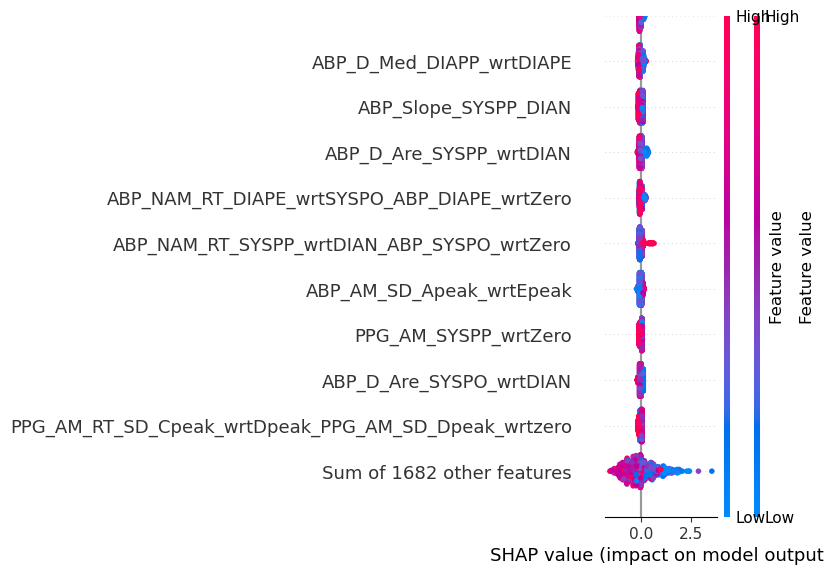

In [122]:
summarize_gbc(best_model, results)


### Saving outputs to file

In [123]:
import json
import numpy as np

def prepare_for_json(d):
    result_json = {}
    for k, v in d.items():
        if k == "shap_values":
            result_json["shap_values"] = v.values.tolist()
            result_json["shap_base"]   = v.base_values.tolist()
            # optionally: result_json["shap_feature_names"] = list(v.feature_names)
            continue

        if isinstance(v, np.ndarray):
            result_json[k] = v.tolist()
        elif isinstance(v, pd.DataFrame):
            result_json[k] = v.to_dict(orient="records")
        else:
            result_json[k] = v
    return result_json

# Prepare
json_ready_results = prepare_for_json(results)

with open(f"outputs/gbc_{FeatureChoice}_model_results.json", "w") as f:
    json.dump(json_ready_results, f, indent=4)


# Save cv_res separately as CSV if preferred
if 'cv_res' in results:
    results['cv_res'].to_csv(f"outputs/gbc_{FeatureChoice}_cv_res.csv", index=False)


In [124]:
import pandas as pd

summary_metrics = {k: v for k, v in results.items() if isinstance(v, (int, float, str))}
pd.DataFrame([summary_metrics]).to_csv(f"outputs/gbc_{FeatureChoice}_model_summary.csv", index=False)


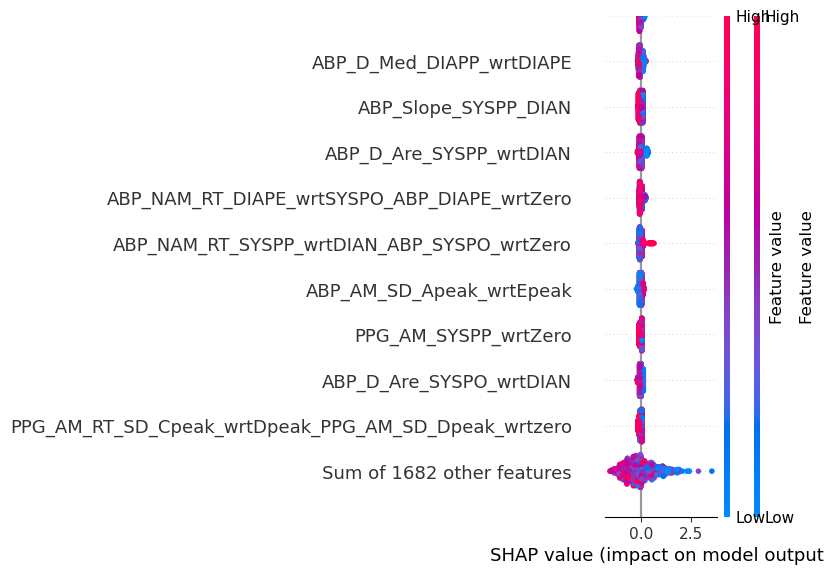

In [125]:
import io
from contextlib import redirect_stdout

f = io.StringIO()
with redirect_stdout(f):
    summarize_gbc(best_model, results)
summary_text = f.getvalue()

with open(f"outputs/gbc_{FeatureChoice}_model_summary.txt", "w") as text_file:
    text_file.write(summary_text)


In [126]:
import matplotlib.pyplot as plt
shap.summary_plot(
    results["shap_values"].values,
    X_test,
    feature_names=feature_names,
    plot_size=[16,8],
    show=False
)
# if saving to file, this keeps all labels
plt.savefig(f"outputs/gbc_{FeatureChoice}_shap_summary_plot.png", bbox_inches="tight", dpi=300) 
plt.close()

shap.plots.beeswarm(results['shap_values'], show=False)
plt.savefig(f"outputs/gbc_{FeatureChoice}_shap_beeswarm_plot.png",
            bbox_inches="tight", dpi=300)
plt.close()


/tmp/ipykernel_1716003/216383341.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


In [127]:
joblib.dump(results['shap_values'], f'outputs/gbc_{FeatureChoice}_shap_values.joblib')

['outputs/gbc_ABP_PPG_shap_values.joblib']

In [128]:
joblib.dump(best_model, f'outputs/gbc_{FeatureChoice}_best_model.joblib')

['outputs/gbc_ABP_PPG_best_model.joblib']

### Finish timing

In [129]:
# Store elapsed and finish time
finish_time = datetime.now()
elapsed_time = finish_time - start_time
log_time("Elapsed", elapsed_time)
log_time("Finish", finish_time)

Elapsed time: 00:35:38

Finish time: 2025-11-30 20:59:54



### DONE

# GBC - SAMPLE NOTEBOOK

In [ ]:
# set_seeds(42)
# model = gbc()
# parameter_space = {
#     'loss':['log_loss','deviance','exponential'],
#     'learning_rate':[0.01,0.1,1],
#     'n_estimators':[100,200],
#     'criterion':['friedman_mse','mse','squared_error'],
#     'min_samples_split':[1,2,3],
#     'min_samples_leaf':[1,2],
#     'max_depth':[2,3,4],
#     'max_features':['auto','sqrt','log2'],


# }

# folds = 4

# skf = StratifiedKFold(n_splits=folds, shuffle = True)

              
# random_search = GridSearchCV(model, parameter_space, scoring=['roc_auc','average_precision'],verbose=2, return_train_score=True, cv=skf.split(X_train,y_train),refit=False)

# # Here we go
# #start_time = timer(None) # timing starts from this point for "start_time" variable

# random_search.fit(X_train, y_train)
# #timer(start_time) # timing ends here for "start_time" variable

# #print(random_search.best_estimator_)
# #print(random_search.best_score_)
# df=pd.DataFrame(random_search.cv_results_)
# df[df["rank_test_roc_auc"]==1][["params","mean_test_roc_auc","std_test_roc_auc","mean_test_average_precision","std_test_average_precision"]]

In [ ]:
# df=pd.DataFrame(random_search.cv_results_)
# df[df["rank_test_roc_auc"]==1][["params","mean_test_roc_auc","std_test_roc_auc","mean_test_average_precision","std_test_average_precision"]]

In [ ]:
# df[df["rank_test_roc_auc"]==1]["params"][df[df["rank_test_roc_auc"]==1]["params"].index[0]]